In [144]:
# Author: Muhammad S. Zainal

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Lasso
from scipy.stats import skew, norm
from scipy import stats

from datetime import datetime

### Load Data

In [145]:
# Only Gosnells and Orange_grove csv files have longitude and latitude columns
gosnells = pd.read_csv('gosnells_master_file.csv')
orange_grove = pd.read_csv('orange_grove_master_file.csv')
gosnells = gosnells.drop(['latitude', 'longitude'], axis=1)
orange_grove = orange_grove.drop(['latitude', 'longitude'], axis=1)

### Combine Data

In [146]:
langford = pd.read_csv('langford_master_file.csv')
huntingdale = pd.read_csv('huntingdale_master_file.csv')
beckenham = pd.read_csv('beckenham_master_file.csv')
kenwick = pd.read_csv('kenwick_master_file.csv')
martin = pd.read_csv('martin_master_file.csv')
thornlie = pd.read_csv('thornlie_master_file.csv')
southern_river = pd.read_csv('southern_river_master_file.csv')
maddington = pd.read_csv('maddington_master_file.csv')
all_data = langford.append(huntingdale)
all_data = all_data.append(beckenham)
all_data = all_data.append(kenwick)
all_data = all_data.append(martin)
all_data = all_data.append(thornlie)
all_data = all_data.append(southern_river)
all_data = all_data.append(maddington)
all_data = all_data.append(gosnells)
all_data = all_data.append(orange_grove)

In [147]:
all_data.head()

,number_first,street_name,street_type_code,locality_name,state_abbreviation,postcode,local_government_area,road_hierarchy,num_bedroom,num_bathroom,num_garage,floor_area,land_area,yr_built,last_sold_date,last_sold_price,land_price
0,3,BAKER,COURT,LANGFORD,WA,6147,GOSNELLS,Access Road,3.0,1.0,2.0,105,710,1978.0,14/07/2003,"$145,000",NaN
1,7,BAKER,COURT,LANGFORD,WA,6147,GOSNELLS,Access Road,4.0,1.0,2.0,124,728,1977.0,11/11/2001,"$98,000",NaN
2,9,BAKER,COURT,LANGFORD,WA,6147,GOSNELLS,Access Road,3.0,1.0,1.0,102,699,1977.0,16/03/2017,"$140,000",NaN
3,11,BAKER,COURT,LANGFORD,WA,6147,GOSNELLS,Access Road,3.0,2.0,2.0,145,699,1983.0,28/06/2010,"$412,000",NaN
4,13,BAKER,COURT,LANGFORD,WA,6147,GOSNELLS,Access Road,NaN,NaN,1.0,100,699,1977.0,10/06/2017,"$332,000",NaN


## Deal with missing values
The following columns contain missing values

In [148]:
all_data.columns[all_data.isna().any()].tolist()

['road_hierarchy',
 'num_bedroom',
 'num_bathroom',
 'num_garage',
 'floor_area',
 'land_area',
 'yr_built',
 'last_sold_date',
 'last_sold_price',
 'land_price']

### Set last_sold_date to NaN where land_price field exists and last_sold_price is NaN
The way the data is structured, last_sold_price value exists when land_price is NaN and vice versa. So if land_price value exists, this means that the last_sold_date was actually a land sale rather than a property sale. Last_sold_date will then be set to NaN in these instances as it will be of little use to us for training due to the lack of the last_sold_price which will be used as the response variable. We then exclude the land_price and street address columns.

In [149]:
#test = all_data[all_data['last_sold_price'].isna()]
all_data.loc[all_data['last_sold_price'].isna(), 'last_sold_date'] = np.NaN
all_data = all_data[['locality_name', 'road_hierarchy', 'num_bedroom', 'num_bathroom','num_garage','floor_area','land_area','yr_built','last_sold_date','last_sold_price']]

### Missing Values: ROAD_HIERARCHY
The most commonly occuring category for ROAD_HIERARCHY is 'Access Road'. We will replace NaNs in this column with this value.

In [150]:
all_data['road_hierarchy'].mode()

0    Access Road
dtype: object

In [151]:
all_data['road_hierarchy'] = all_data['road_hierarchy'].fillna('Access Road')

### Missing Values: YR_BUILT, NUM_BATHROOM, NUM_GARAGE
Fill NaN in yr_built, num_bedroom, num_bathroom and num_garage with median grouped by the locality_name category

In [152]:
all_data['yr_built'].isna().sum()
print(all_data.groupby('locality_name').median())
print(all_data.groupby('locality_name').mean())

                num_bedroom  num_bathroom  num_garage  yr_built
locality_name                                                  
BECKENHAM               3.0           1.0         2.0    1974.0
GOSNELLS                3.0           1.0         1.0    1981.0
HUNTINGDALE             4.0           2.0         2.0    1991.0
KENWICK                 3.0           1.0         2.0    1987.0
LANGFORD                3.0           1.0         1.0    1977.0
MADDINGTON              3.0           1.0         1.0    1982.0
MARTIN                  4.0           2.0         2.0    1999.0
ORANGE GROVE            4.0           2.0         2.0    1982.0
SOUTHERN RIVER          4.0           2.0         2.0    2011.0
THORNLIE                4.0           1.0         2.0    1983.0
                num_bedroom  num_bathroom  num_garage     yr_built
locality_name                                                     
BECKENHAM          3.415162      1.430253    1.864482  1981.557377
GOSNELLS           3.380757    

In [153]:
all_data['yr_built'] = all_data['yr_built'].fillna(all_data.groupby('locality_name')['yr_built'].transform('median'))
all_data['num_bedroom'] = all_data['num_bedroom'].fillna(all_data.groupby('locality_name')['num_bedroom'].transform('median'))
all_data['num_bathroom'] = all_data['num_bathroom'].fillna(all_data.groupby('locality_name')['num_bathroom'].transform('median'))
all_data['num_garage'] = all_data['num_garage'].fillna(all_data.groupby('locality_name')['num_garage'].transform('median'))

### Missing Values: FLOOR_AREA, LAND_AREA
Fill NaN in floor area and land area with mean. Dashes were also present in this dataset to signify missing values so the relevant data cleaning is performed

In [154]:
all_data[all_data['land_area']=='-'] #Number of NaN

,locality_name,road_hierarchy,num_bedroom,num_bathroom,num_garage,floor_area,land_area,yr_built,last_sold_date,last_sold_price
1610,BECKENHAM,Access Road,3.0,2.0,2.0,-,-,1974.0,NaN,NaN
1968,BECKENHAM,Access Road,3.0,2.0,2.0,-,-,1974.0,NaN,NaN
293,MARTIN,Access Road,1.0,1.0,1.0,-,-,1999.0,NaN,NaN
545,MARTIN,Access Road,4.0,2.0,2.0,-,-,1999.0,NaN,NaN
2918,SOUTHERN RIVER,Access Road,4.0,2.0,2.0,-,-,2011.0,NaN,NaN
1461,MADDINGTON,Access Road,1.0,1.0,1.0,-,-,1982.0,NaN,NaN
2619,MADDINGTON,Local Distributor,3.0,1.0,1.0,104,-,1982.0,NaN,NaN
366,GOSNELLS,Access Road,3.0,1.0,1.0,-,-,1981.0,NaN,NaN
2046,GOSNELLS,Access Road,4.0,2.0,2.0,-,-,1981.0,NaN,NaN
2330,GOSNELLS,Distributor B,2.0,1.0,1.0,-,-,1981.0,NaN,NaN


In [155]:
all_data.loc[all_data['land_area'] == '-', ['land_area']] = np.NaN
all_data.loc[all_data['floor_area'] == '-', ['floor_area']] = np.NaN
all_data.loc[all_data['floor_area'] == '/', ['floor_area']] = np.NaN

Change to numeric type to calculate mean

In [156]:
all_data['floor_area'] = pd.to_numeric(all_data['floor_area'])
all_data['land_area'] = pd.to_numeric(all_data['land_area']) 

Replace missing values with mean

In [157]:
all_data['floor_area'] = all_data['floor_area'].fillna(all_data.groupby('locality_name')['floor_area'].transform('mean'))
all_data['land_area'] = all_data['land_area'].fillna(all_data.groupby('locality_name')['land_area'].transform('mean'))

## Feature Engineering

### Retrieve the year from the date column
For the purposes of reducing the amount of potential variables, we retrieve only the year from the date column. Including the months or days could lead to far too many dummy variables when we perform One-Hot Encoding later on.

In [158]:
all_data['year_sold']= pd.DatetimeIndex(all_data['last_sold_date']).year

In [159]:
all_data = all_data.drop(columns='last_sold_date')

### Create age_when_sold

In [160]:
all_data['age_when_sold'] = all_data['year_sold'] - all_data['yr_built']

### Strip non-numeric characters from last_sold_price

In [161]:
all_data['last_sold_price'] = all_data['last_sold_price'].str.strip('$').str.replace(',','')
all_data['last_sold_price'] = pd.to_numeric(all_data['last_sold_price'])

### year_sold and yr_built are converted to categorical variables

In [162]:
all_data['year_sold'] = all_data['year_sold'].astype('category')
all_data['yr_built'] = all_data['yr_built'].astype('category')

### Houses with a land area less than 50 are considered commercial or farmland. (Scraper removed the 'ha' unit)
The web scraper used removed all non-numeric characters after the land area value like 'm2' (squared metres) and 'ha' (hectares). Since these measurement characters are lost and there is no other way to indicate if a value uses one measurement or the other, a value of 50 was arbitrarily picked to provide a cut-off point to indicate that any numerical value lesser than this is assumed to be in hectares rather than squared metres.

In [163]:
all_data.loc[all_data['land_area'] < 50].sort_values(by=['land_area'], ascending=False)

,locality_name,road_hierarchy,num_bedroom,num_bathroom,num_garage,floor_area,land_area,yr_built,last_sold_price,year_sold,age_when_sold
847,KENWICK,Local Distributor,3.0,1.0,2.0,155.767737,34.55,1987.0,NaN,NaN,NaN
183,MARTIN,Access Road,4.0,2.0,2.0,204.935563,28.64,1999.0,NaN,NaN,NaN
487,MARTIN,Access Road,4.0,2.0,2.0,204.935563,24.51,1999.0,NaN,NaN,NaN
1075,MADDINGTON,Access Road,3.0,1.0,1.0,190.055534,24.24,1982.0,NaN,NaN,NaN
188,ORANGE GROVE,Access Road,4.0,2.0,2.0,255.698909,19.79,1982.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
160,ORANGE GROVE,Access Road,3.0,1.0,2.0,255.698909,1.00,1926.0,725000.0,2012.0,86.0
78,ORANGE GROVE,Access Road,5.0,3.0,4.0,249.000000,1.00,2018.0,NaN,NaN,NaN
76,ORANGE GROVE,Access Road,4.0,2.0,2.0,255.698909,1.00,1982.0,NaN,NaN,NaN
851,KENWICK,Local Distributor,2.0,1.0,2.0,136.000000,1.00,1924.0,140000.0,1996.0,72.0


In [164]:
all_data = all_data[all_data['land_area'] > 50]
original_df = all_data.copy()

## Analyse Distributions

c:\users\mazza\desktop\kaggle comps\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\mazza\desktop\kaggle comps\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\mazza\desktop\kaggle comps\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

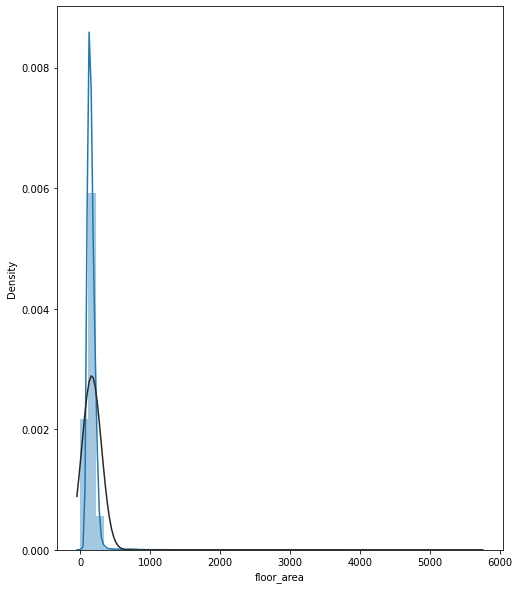

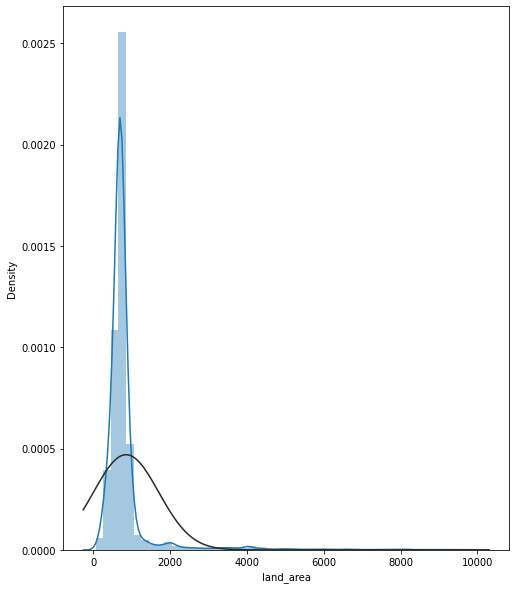

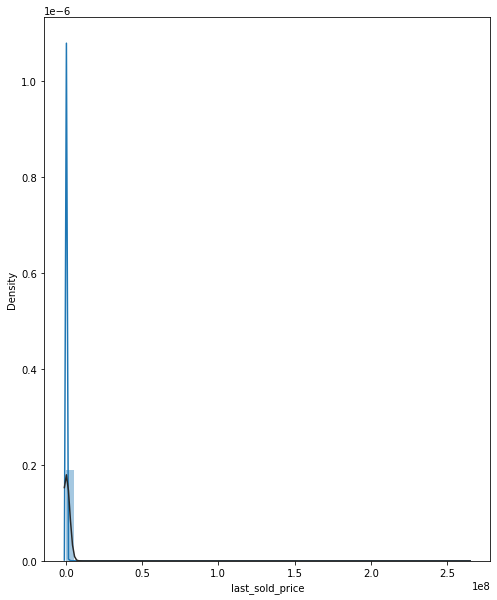

<Figure size 576x720 with 0 Axes>

In [165]:
#histogram and normal probability plot
sns.distplot(all_data['floor_area'], fit=norm)
fig = plt.figure()
sns.distplot(all_data['land_area'], fit=norm)
fig = plt.figure()
sns.distplot(all_data['last_sold_price'], fit=norm)
fig = plt.figure()

### Log-transform variables and graph them

c:\users\mazza\desktop\kaggle comps\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\mazza\desktop\kaggle comps\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\mazza\desktop\kaggle comps\venv\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

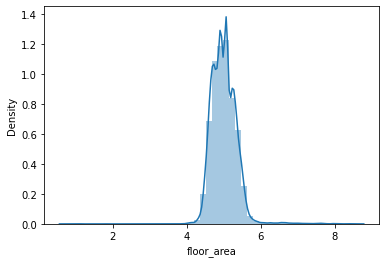

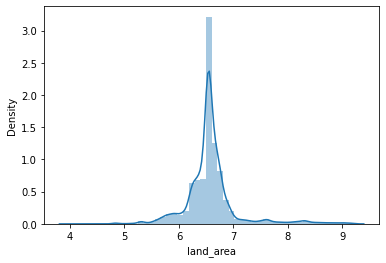

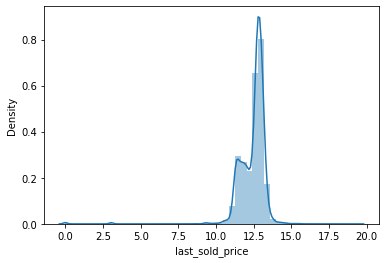

<Figure size 432x288 with 0 Axes>

In [111]:
#histogram and normal probability plot log distributed
sns.distplot(np.log1p(all_data['floor_area']))
fig = plt.figure()
sns.distplot(np.log1p(all_data['land_area']))
fig = plt.figure()
sns.distplot(np.log1p(all_data['last_sold_price']))
fig = plt.figure()

### Perform transformations

In [166]:
all_data['floor_area'] = np.log1p(all_data['floor_area'])
all_data['land_area'] = np.log1p(all_data['land_area'])
all_data['last_sold_price'] = np.log1p(all_data['last_sold_price'])

### Test data inputs
As mentioned before, our response variable is last_sold_price. The last_sold_date will be set to 2019 to predict the real estate prices to this date. Recall that we set multiple rows to NaN in one of the earlier code blocks. Those rows will be our test split.

In [167]:
#all_data['age_when_sold'] = 2020 - all_data.loc[all_data['last_sold_price'].isna(), all_data['yr_built']]
all_data['yr_built'] = pd.to_numeric(all_data['yr_built']) 

In [168]:
#all_data.loc[all_data['last_sold_price'].isna(), ['age_when_sold']] 
all_data['age_when_sold'] = np.where(all_data['age_when_sold'].isna(), 2019 - all_data['yr_built'], all_data['age_when_sold'])
#Change the year for a different result  ----------------------------   ^

### Set Dummy Variables: YR_BUILT, YEAR_SOLD

In [169]:
all_data = all_data[all_data['yr_built'] >= 1900]
all_data['yr_built'] = all_data['yr_built'].astype('category')
original_len = all_data.shape[0]
a = all_data.iloc[0].copy()
a[:] = np.NaN
for i in range(1900, 2021+1):
    a['yr_built'] = i
    a['year_sold'] = i
    all_data = all_data.append(a)
    

    
all_data = pd.get_dummies(all_data, columns=['yr_built'])
all_data = pd.get_dummies(all_data, columns=['year_sold'])
all_data = all_data[:original_len]

### Train test split

In [170]:
test = all_data[all_data['last_sold_price'].isna()]
train = all_data[all_data['last_sold_price'].notna()]

In [171]:
test['year_sold_2019.0'] = 1  #Change the year for a different result

<ipython-input-171-c7c5b826002b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['year_sold_2019.0'] = 1  #Change the year for a different result


### Set Dummy Variables: LOCALITY_NAME, ROAD_HIERARCHY

In [172]:
#all_data = pd.get_dummies(all_data)
train = pd.get_dummies(train, columns=['locality_name','road_hierarchy'])
test = pd.get_dummies(test, columns=['locality_name','road_hierarchy'])

In [141]:
test

,num_bedroom,num_bathroom,num_garage,floor_area,land_area,age_when_sold,yr_built_1900.0,yr_built_1901.0,yr_built_1902.0,yr_built_1903.0,yr_built_1904.0,yr_built_1905.0,yr_built_1906.0,yr_built_1907.0,yr_built_1908.0,yr_built_1909.0,yr_built_1910.0,yr_built_1911.0,yr_built_1912.0,yr_built_1913.0,yr_built_1914.0,yr_built_1915.0,yr_built_1916.0,yr_built_1917.0,yr_built_1918.0,yr_built_1919.0,yr_built_1920.0,yr_built_1921.0,yr_built_1922.0,yr_built_1923.0,yr_built_1924.0,yr_built_1925.0,yr_built_1926.0,yr_built_1927.0,yr_built_1928.0,yr_built_1929.0,yr_built_1930.0,yr_built_1931.0,yr_built_1932.0,yr_built_1933.0,yr_built_1934.0,yr_built_1935.0,yr_built_1936.0,yr_built_1937.0,yr_built_1938.0,yr_built_1939.0,yr_built_1940.0,yr_built_1941.0,yr_built_1942.0,yr_built_1943.0,yr_built_1944.0,yr_built_1945.0,yr_built_1946.0,yr_built_1947.0,yr_built_1948.0,yr_built_1949.0,yr_built_1950.0,yr_built_1951.0,yr_built_1952.0,yr_built_1953.0,yr_built_1954.0,yr_built_1955.0,yr_built_1956.0,yr_built_1957.0,yr_built_1958.0,yr_built_1959.0,yr_built_1960.0,yr_built_1961.0,yr_built_1962.0,yr_built_1963.0,yr_built_1964.0,yr_built_1965.0,yr_built_1966.0,yr_built_1967.0,yr_built_1968.0,yr_built_1969.0,yr_built_1970.0,yr_built_1971.0,yr_built_1972.0,yr_built_1973.0,yr_built_1974.0,yr_built_1975.0,yr_built_1976.0,yr_built_1977.0,yr_built_1978.0,yr_built_1979.0,yr_built_1980.0,yr_built_1981.0,yr_built_1982.0,yr_built_1983.0,yr_built_1984.0,yr_built_1985.0,yr_built_1986.0,yr_built_1987.0,yr_built_1988.0,yr_built_1989.0,yr_built_1990.0,yr_built_1991.0,yr_built_1992.0,yr_built_1993.0,yr_built_1994.0,yr_built_1995.0,yr_built_1996.0,yr_built_1997.0,yr_built_1998.0,yr_built_1999.0,yr_built_2000.0,yr_built_2001.0,yr_built_2002.0,yr_built_2003.0,yr_built_2004.0,yr_built_2005.0,yr_built_2006.0,yr_built_2007.0,yr_built_2008.0,yr_built_2009.0,yr_built_2010.0,yr_built_2011.0,yr_built_2012.0,yr_built_2013.0,yr_built_2014.0,yr_built_2015.0,yr_built_2016.0,yr_built_2017.0,yr_built_2018.0,yr_built_2019.0,yr_built_2020.0,yr_built_2021.0,year_sold_1900.0,year_sold_1901.0,year_sold_1902.0,year_sold_1903.0,year_sold_1904.0,year_sold_1905.0,year_sold_1906.0,year_sold_1907.0,year_sold_1908.0,year_sold_1909.0,year_sold_1910.0,year_sold_1911.0,year_sold_1912.0,year_sold_1913.0,year_sold_1914.0,year_sold_1915.0,year_sold_1916.0,year_sold_1917.0,year_sold_1918.0,year_sold_1919.0,year_sold_1920.0,year_sold_1921.0,year_sold_1922.0,year_sold_1923.0,year_sold_1924.0,year_sold_1925.0,year_sold_1926.0,year_sold_1927.0,year_sold_1928.0,year_sold_1929.0,year_sold_1930.0,year_sold_1931.0,year_sold_1932.0,year_sold_1933.0,year_sold_1934.0,year_sold_1935.0,year_sold_1936.0,year_sold_1937.0,year_sold_1938.0,year_sold_1939.0,year_sold_1940.0,year_sold_1941.0,year_sold_1942.0,year_sold_1943.0,year_sold_1944.0,year_sold_1945.0,year_sold_1946.0,year_sold_1947.0,year_sold_1948.0,year_sold_1949.0,year_sold_1950.0,year_sold_1951.0,year_sold_1952.0,year_sold_1953.0,year_sold_1954.0,year_sold_1955.0,year_sold_1956.0,year_sold_1957.0,year_sold_1958.0,year_sold_1959.0,year_sold_1960.0,year_sold_1961.0,year_sold_1962.0,year_sold_1963.0,year_sold_1964.0,year_sold_1965.0,year_sold_1966.0,year_sold_1967.0,year_sold_1968.0,year_sold_1969.0,year_sold_1970.0,year_sold_1971.0,year_sold_1972.0,year_sold_1973.0,year_sold_1974.0,year_sold_1975.0,year_sold_1976.0,year_sold_1977.0,year_sold_1978.0,year_sold_1979.0,year_sold_1980.0,year_sold_1981.0,year_sold_1982.0,year_sold_1983.0,year_sold_1984.0,year_sold_1985.0,year_sold_1986.0,year_sold_1987.0,year_sold_1988.0,year_sold_1989.0,year_sold_1990.0,year_sold_1991.0,year_sold_1992.0,year_sold_1993.0,year_sold_1994.0,year_sold_1995.0,year_sold_1996.0,year_sold_1997.0,year_sold_1998.0,year_sold_1999.0,year_sold_2000.0,year_sold_2001.0,year_sold_2002.0,year_sold_2003.0,year_sold_2004.0,year_sold_2005.0,year_sold_2006.0,year_sold_2007.0,year_sold_2008.0,year_sold_2009.0,year_sold_2010.0,year_sold_2011.0,year_sold_2012.0,year_sold_2013.0,year_sold_2014.0,year_sold_2015.0,year

### Set Response Variable

In [173]:
test = test.drop(columns='last_sold_price')
y = train.last_sold_price
train = train.drop(columns='last_sold_price')

In [174]:
X_train = train
X_test = test
#y = train.last_sold_price

## Model
Due to the prevalence of a large number of dummy variables, we use a lasso regression approach.

In [122]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [123]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [124]:
model_lasso = LassoCV(alphas = [0.0005, 0.001, 0.1, 1]).fit(X_train, y)

### Root Mean Squared Error

In [126]:
rmse_cv(model_lasso).mean()

0.7707788040599537

In [127]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [128]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 94 variables and eliminated the other 171 variables


### The most relevant coefficients
We visualise 30 coefficients that have the strongest positive effect on the response variable and the 30 that have the strongest negative effect. The years between 2006-2016 appear to have the strongest positive effects. This is in line with the broader mining boom that occured in Western Australia, which brought growth in several categories within the state including real estate. Subsequent years provide a relatively weaker positive effect. These trends appear to be in line with those provided by [REIWA](https://reiwa.com.au/uploadedfiles/public/content/the_wa_market/house-prices-2013-web.pdf).

Aside from the year, land area and floor area provided the next highest coefficients. In terms of locality, Southern River, a new developing suburb, provided the highest positive coefficient while Martin, a scarcely-populated rural suburb provided the highest negative coefficient.

In [129]:
imp_coef = pd.concat([coef.sort_values().head(30),
                     coef.sort_values().tail(30)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

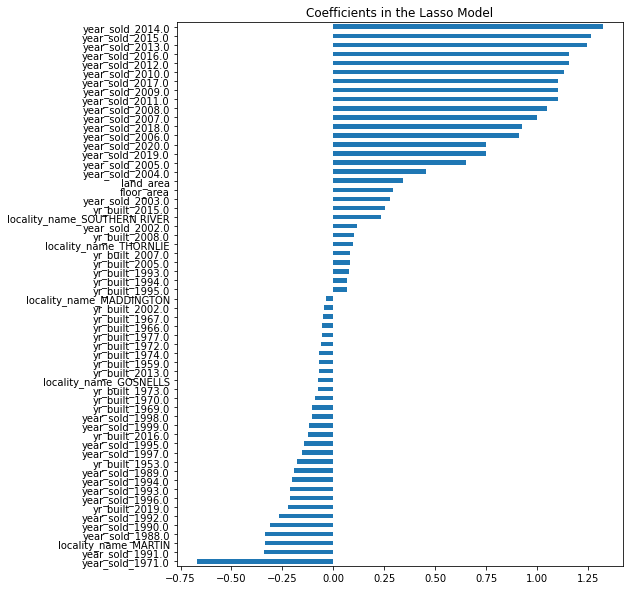

In [130]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Predictions for test set

In [134]:
preds = model_lasso.predict(X_test)
preds = np.expm1(preds)

In [136]:
len(preds)

11817

### Append predictions to original test data

In [178]:
original_df = original_df[original_df['last_sold_price'].isna()]
original_df['predicted_price'] = preds

In [183]:
original_df['year_sold'] = original_df['year_sold'].fillna(2019)

In [194]:
original_df['age_when_sold'] = pd.to_numeric(original_df['age_when_sold'])
original_df['year_sold'] = pd.to_numeric(original_df['year_sold'])
original_df['yr_built'] = pd.to_numeric(original_df['yr_built'])
original_df['age_when_sold'] = original_df['year_sold'] - original_df['yr_built']

In [198]:
original_df = original_df.drop(columns='last_sold_price')

In [199]:
original_df

,locality_name,road_hierarchy,num_bedroom,num_bathroom,num_garage,floor_area,land_area,yr_built,year_sold,age_when_sold,predicted_price
10,LANGFORD,Access Road,3.0,1.0,1.0,105.000000,788.000000,1983.0,2019.0,36.0,216317.278884
12,LANGFORD,Access Road,3.0,1.0,1.0,105.000000,722.000000,1977.0,2019.0,42.0,195279.199762
16,LANGFORD,Access Road,4.0,1.0,2.0,192.080000,432.000000,2004.0,2019.0,15.0,228915.930557
17,LANGFORD,Access Road,4.0,1.0,1.0,90.000000,414.000000,2004.0,2019.0,15.0,177431.853199
19,LANGFORD,Access Road,4.0,1.0,2.0,163.000000,414.000000,2006.0,2019.0,13.0,229597.327281
...,...,...,...,...,...,...,...,...,...,...,...
174,ORANGE GROVE,Access Road,4.0,2.0,2.0,255.698909,660.877463,1982.0,2019.0,37.0,288260.435771
202,ORANGE GROVE,Access Road,4.0,2.0,2.0,255.698909,660.877463,1982.0,2019.0,37.0,288260.435771
209,ORANGE GROVE,Access Road,4.0,1.0,2.0,220.000000,4002.000000,1986.0,2019.0,33.0,500243.000235
222,ORANGE GROVE,Access Road,4.0,2.0,2.0,255.698909,660.877463,1982.0,2019.0,37.0,288260.435771


### Model saving

In [352]:
import joblib

# Save to file in the current working directory
joblib_file = "joblib_model.pkl"
joblib.dump(model_lasso, joblib_file)

['joblib_model.pkl']

In [144]:
X = X_test.iloc[0:1]

In [145]:
# Load from file
joblib_model = joblib.load(joblib_file)

Ypredict = joblib_model.predict(X)